<h5 align="left">IBM Machine Learning Course - Classification Final Project</h5>

<h2 align="center">Predicting Heart Disease With Machine Learning</h2>

#### Major objective of the analysis  

For this exercise, we will be using the heart disease dataset from UCI Machine Learning Repository (https://archive.ics.uci.edu/dataset/45/heart+disease). The major objective is to predict the presence of heart disease using clinical parameters. The models could help doctors select patients for further assessment and follow-up.

We will train four classifiers (logistic regression, support vecter machine, random forest, and XGBoost) for their difference in complexity, training speed and explainability. with the same train and test splits and compare their prediction performance. The results will be used for recommending a final model for this dataset. Note that this dataset (303 clinical cases; 164 cases didn’t have heart disease while 139 cases have) is relatively small, therefore the models may not generalize well to other datasets, but they can be used as starting points.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, accuracy_score 
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import precision_score, recall_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

### The dataset

In [2]:
# %pip install ucimlrepo # Install the packge if needed

# Heart disease data
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 

df = pd.concat([heart_disease.data.features, heart_disease.data.targets], axis=1)

The heart disease repository includes four databases: Cleveland, Hungary, Switzerland, and the VA Long Beach. According to data information, “This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to date.” Therefore, we will be using the Cleveland database with 14 features, “simply attempting to distinguish presence (values 1, 2, 3, 4) from absence (value 0)” as other researchers did. Specifically, we will be using the processed Cleveland data which is “in good shape and is usable (for the 14 attributes situation)” because the original one was messed up due to computer failure (see the “WARNING” in downloaded folder).  

The Cleveland dataset includes 303 patients with the following clinical information:

1. sex - (1 = male; 0 = female)
2. age - age in years
3. cp - chest pain type (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4
= asymptomatic)
4. trestbps - resting blood pressure in mmHg on admission to the hospital
5. chol - serum cholesterol in mg/dl
6. fbs - fasting blood sugar > 120 mg/dl (1 = true, 0 = false)
7. restecg - resting electrocardiographic results (0 = normal, 1 = having ST-T wave
abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 2
= showing probable or definite left ventricular hypertrophy by Estes' criteria)
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest
11. slope - the slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 =
downsloping)
12. ca - number of major vessels (0-3) colored by flourosopy
13. thal – thalassemia (3 = normal, 6 = fixed defect, 7 = reversable defect)
14. num - diagnosis of heart disease (0 = no, 1-4 = yes)

### Data exploration, cleaning, and feature engineering

Below We will look at the data in detail, looking at missing data and the correlation between features and target.

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


**Data types**. Original data has categorical and numeric data, but because this set is a processed dataset, all the features are now integer (11) or float type (3), as shown below from data information output:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


In [5]:
df.dtypes.value_counts()

int64      11
float64     3
Name: count, dtype: int64

Age, trestbps, chol, thalach, ca, and oldpeak continuous features 6.  
Sex, fbs, exang, and num are binary 4.  
Restecg, cp, slope are ordinal 3.   

In [6]:
print(df.cp.value_counts())
print(df.fbs.value_counts())
print(df.restecg.value_counts())
print(df.exang.value_counts())
print(df.slope.value_counts())
print(df.ca.value_counts)

cp
4    144
3     86
2     50
1     23
Name: count, dtype: int64
fbs
0    258
1     45
Name: count, dtype: int64
restecg
0    151
2    148
1      4
Name: count, dtype: int64
exang
0    204
1     99
Name: count, dtype: int64
slope
1    142
2    140
3     21
Name: count, dtype: int64
<bound method IndexOpsMixin.value_counts of 0      0.0
1      3.0
2      2.0
3      0.0
4      0.0
      ... 
298    0.0
299    2.0
300    1.0
301    1.0
302    NaN
Name: ca, Length: 303, dtype: float64>


In [7]:
# metadata
for key, value in heart_disease.metadata.items():
    print(key, ":", value)

uci_id : 45
name : Heart Disease
repository_url : https://archive.ics.uci.edu/dataset/45/heart+disease
data_url : https://archive.ics.uci.edu/static/public/45/data.csv
abstract : 4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach
area : Health and Medicine
tasks : ['Classification']
characteristics : ['Multivariate']
num_instances : 303
num_features : 13
feature_types : ['Categorical', 'Integer', 'Real']
demographics : ['Age', 'Sex']
target_col : ['num']
index_col : None
has_missing_values : yes
missing_values_symbol : NaN
year_of_dataset_creation : 1989
last_updated : Fri Nov 03 2023
dataset_doi : 10.24432/C52P4X
creators : ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano']
intro_paper : {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sandhu, K. Guppy, S. Lee, V. Froe

In [8]:
# variable information 
print(heart_disease.variables) 

        name     role         type demographic  \
0        age  Feature      Integer         Age   
1        sex  Feature  Categorical         Sex   
2         cp  Feature  Categorical        None   
3   trestbps  Feature      Integer        None   
4       chol  Feature      Integer        None   
5        fbs  Feature  Categorical        None   
6    restecg  Feature  Categorical        None   
7    thalach  Feature      Integer        None   
8      exang  Feature  Categorical        None   
9    oldpeak  Feature      Integer        None   
10     slope  Feature  Categorical        None   
11        ca  Feature      Integer        None   
12      thal  Feature  Categorical        None   
13       num   Target      Integer        None   

                                          description  units missing_values  
0                                                None  years             no  
1                                                None   None             no  
2              

In [9]:
df.thal.unique()

array([ 6.,  3.,  7., nan])

**Basic description of the data**. As typically seen, clinical test results (such as trestbps, chol, thalach, and oldpeak) can have wide ranges. Feature values are on various scales.

In [10]:
df.describe().round(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,299.00,301.00,303.00
mean,54.44,0.68,3.16,131.69,246.69,0.15,0.99,149.61,0.33,1.04,1.60,0.67,4.73,0.94
std,9.04,0.47,0.96,17.60,51.78,0.36,0.99,22.88,0.47,1.16,0.62,0.94,1.94,1.23
min,29.00,0.00,1.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,1.00,0.00,3.00,0.00
25%,48.00,0.00,3.00,120.00,211.00,0.00,0.00,133.50,0.00,0.00,1.00,0.00,3.00,0.00
50%,56.00,1.00,3.00,130.00,241.00,0.00,1.00,153.00,0.00,0.80,2.00,0.00,3.00,0.00
75%,61.00,1.00,4.00,140.00,275.00,0.00,2.00,166.00,1.00,1.60,2.00,1.00,7.00,2.00
max,77.00,1.00,4.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,3.00,3.00,7.00,4.00


**Missing data and treatment**. There are missing values: 2 in thal (Table 3), and 4 in ca (Table 4). The dataset is relatively small as are the missing values, so the missing values were filled using pandas.fillna() function to keep the samples

In [11]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64

Rename the target (num) column to 'disease' for clarity.
Change all the numbers (1-4) other than 0 (no) to 1 (yes).

In [12]:
df2 = df.copy()
df2.columns = list(df2)[:-1] + ['disease']
df2['disease'] = [1 if i != 0 else 0 for i in df2.disease]
df2.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [13]:
df.num.value_counts()

num
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

In [14]:
df2.disease.value_counts()

disease
0    164
1    139
Name: count, dtype: int64

In [15]:
df[df.ca.isnull()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
166,52,1,3,138,223,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247,1,2,143,1,0.1,2,NaN,7.0,1
287,58,1,2,125,220,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3.0,0


In [16]:
df[df.thal.isnull()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
87,53,0,3,128,216,0,2,115,0,0.0,1,0.0,NaN,0
266,52,1,4,128,204,1,0,156,1,1.0,2,0.0,NaN,2


Because the dataset is small and there are only a few missing values, we will keep the missing data and fill the missing value using ffill method (from pandas guide: "Fill values by propagating the last valid observation to next valid.")    
Check the data for sure.

In [17]:
df2 = df2.ffill()
df2.iloc[[87, 266], :]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
87,53,0,3,128,216,0,2,115,0,0.0,1,0.0,3.0,0
266,52,1,4,128,204,1,0,156,1,1.0,2,0.0,6.0,1


In [18]:
df2.iloc[[166, 192, 287, 302], :]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
166,52,1,3,138,223,0,0,169,0,0.0,1,0.0,3.0,0
192,43,1,4,132,247,1,2,143,1,0.1,2,3.0,7.0,1
287,58,1,2,125,220,0,0,144,0,0.4,2,2.0,7.0,0
302,38,1,3,138,175,0,0,173,0,0.0,1,1.0,3.0,0


**Other treatment**. To simplify this initial analysis, we will also change thal to presence or absence, 
with original value 3 (normal) set to 0 and 6 and 7 (defective) set to 1.

In [19]:
df2['thal'] = [0 if i == 3.0 else 1 for i in df2.thal]
df2.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,1,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,1,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,0,0


**“Outliers” and data skews**. “Outliers” are seen in some features particularly chol and oldpeak, but these are most likely biological, therefore being left as are. Some skews can be seen in chol (1.1, right skew), age (-0.21, left skew), and 5 of 1 
trestbps (0.7, right skew). Again, these could be biological. We will normalize the data before splitting.

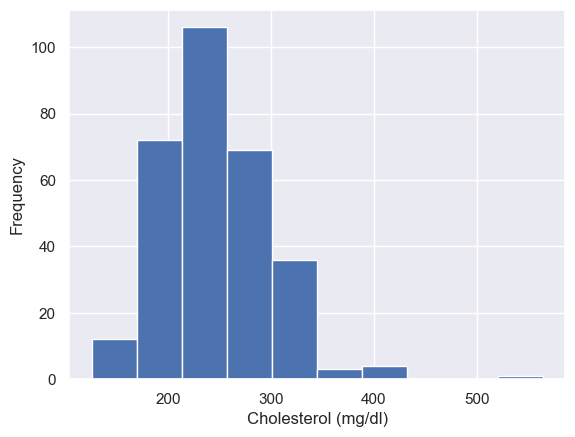

In [20]:
df2.chol.plot(kind='hist', xlabel='Cholesterol (mg/dl)');

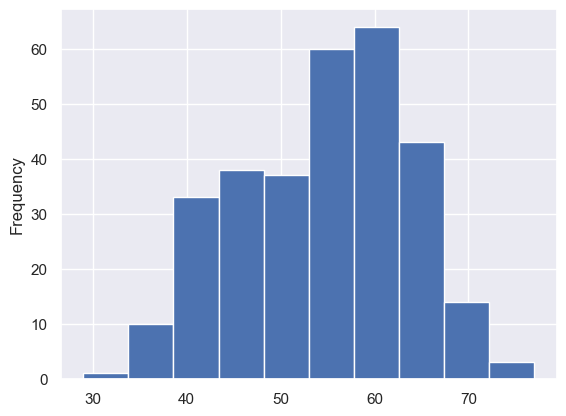

In [25]:
df2.age.plot(kind='hist');

In [26]:
df2.chol.skew()

1.1355031533363453

In [27]:
df2.age.skew()

-0.20906046882012877

0.7060346498131783


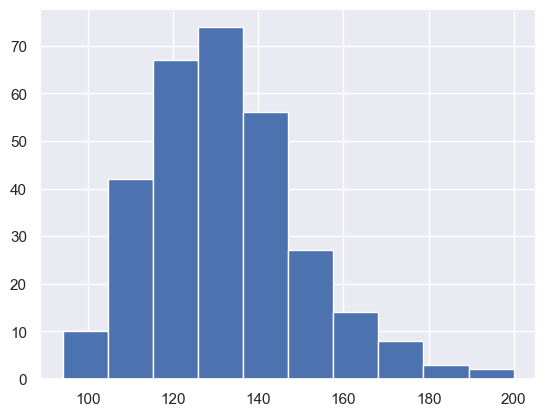

In [28]:
df2.trestbps.hist();
print(df2.trestbps.skew())

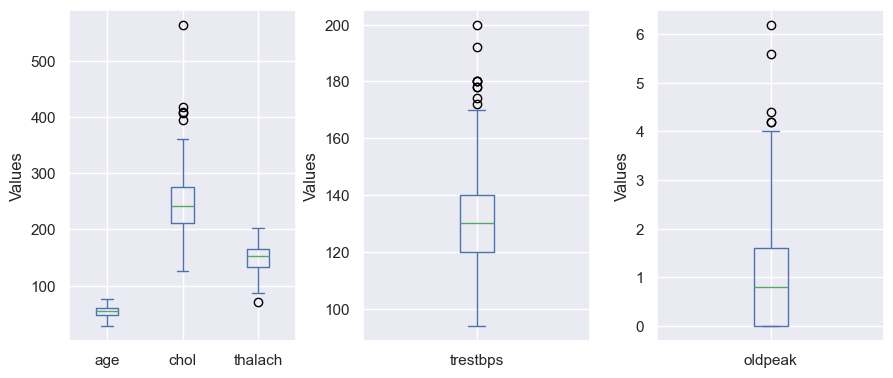

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 4))
plt.subplots_adjust(wspace=0.4)
fig.tight_layout()
df2[['age', 'chol', 'thalach']].plot(kind='box', ylabel='Values', ax=ax1);
df2[['trestbps']].plot(kind='box', ylabel='Values', ax=ax2);
df2[['oldpeak']].plot(kind='box', ylabel='Values', ax=ax3);

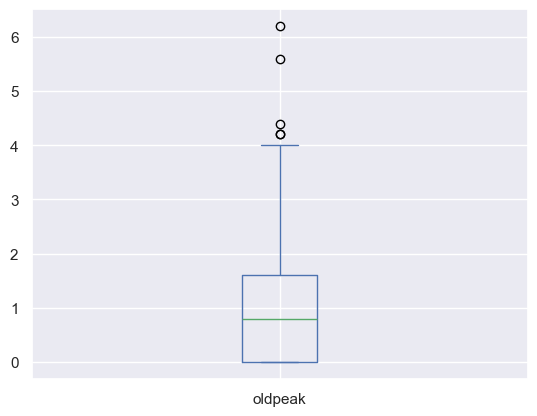

In [30]:
df2['oldpeak'].plot(kind='box');

<Axes: >

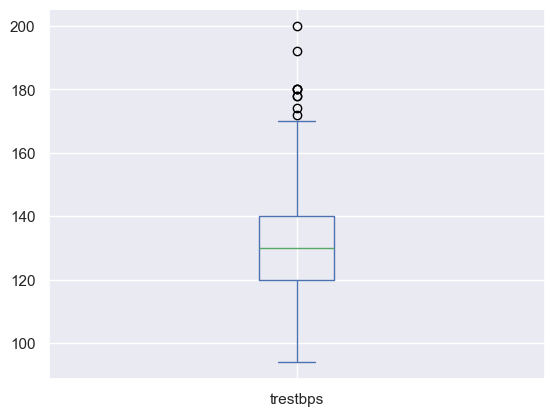

In [31]:
df2['trestbps'].plot(kind='box')

**Feature correlations**. From the heatmap, it appears that thal, ca, exang, oldpeak, and cp have > 0.4 positive, while thalach stands out as having – 0.4, correlation with disease. Some correlations can be found between other features (slope with oldpeak for example).

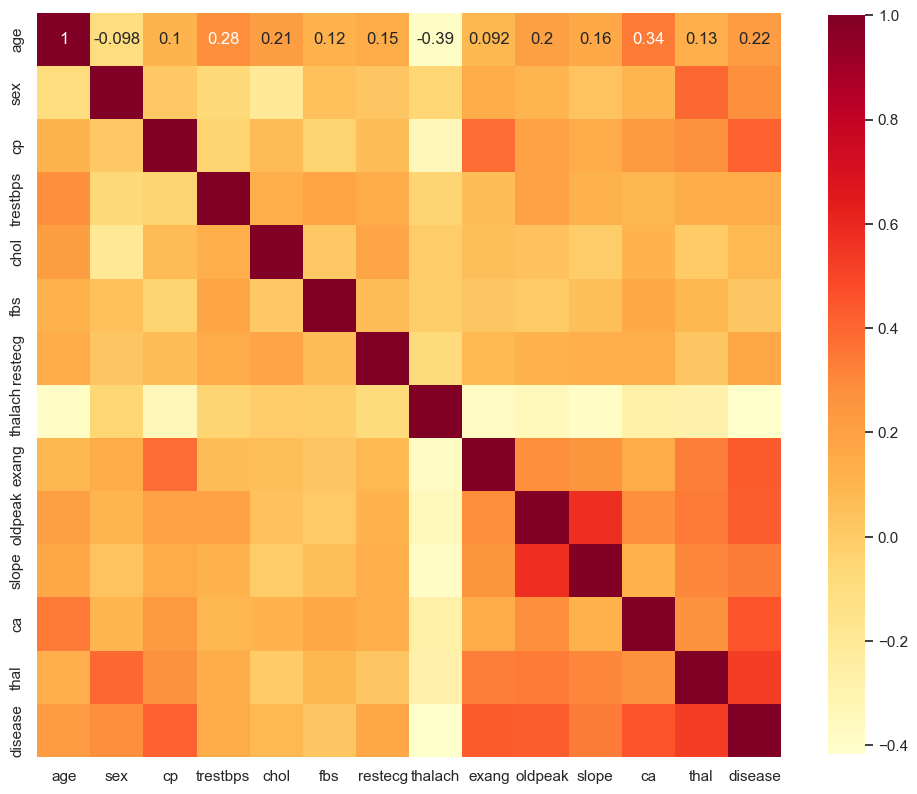

In [32]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df2.corr(), cmap='YlOrRd', square=True, annot=True, ax=ax, cbar_kws={"shrink": .8});

**Feature engineering**. The features can be put into three categories: continuous (age, trestbps, chol, thalach, ca, and oldpeak); binary (sex, fbs, and exang); and ordinal (restecg, cp, and slope). They are already numeric. Thal is unique in values (3 = normal, 6 = fixed defect, 7 = reversable defect) with unclear meanings for their scales. For simplicity, previously we changed the values (3 to 0, 6 and 7 to 1), turning it into a binary feature. The num (target) was ordinal. We changed the name to “disease” for clarity with all values other than 0 changed to 1 (indicating presence of the disease), also turning it into binary as in published studies. Finally, data were scaled with StandardScaler.

All features will be used for modeling as previous studies did.

**Class balance**. The cases with or without heart disease are 164 and 139, respectively, therefore the target classes are relatively balanced; stratification will be used when splitting the data.

In [33]:
df2.disease.value_counts()

disease
0    164
1    139
Name: count, dtype: int64

### Model training and evaluation metrics

The data was split into X (features) and y (target), and then X was scaled with StandardScaler. X and y were then split into training and test sets stratification (test size = 0.25). These training and test sets were used for training and prediction of four classifiers (linear regression, support vector machine (SVM), random forest, and XGBoost classifiers). For each classifier, sklearn GridSearchCV cross-validation was used to optimize hyperparameters.

**Data split and normalization**.

In [34]:
X = df2[list(df2)[:-1]]
y = df2.disease

In [35]:
X_scaled = X.copy
scaler  = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.94872647,  0.68620244, -2.25177456, ...,  2.27457861,
        -0.72427225,  1.10812507],
       [ 1.39200191,  0.68620244,  0.87798549, ...,  0.64911323,
         2.45622764, -0.90242521],
       [ 1.39200191,  0.68620244,  0.87798549, ...,  0.64911323,
         1.39606101,  1.10812507],
       ...,
       [ 0.28381332,  0.68620244,  0.87798549, ...,  0.64911323,
         0.33589438,  1.10812507],
       [ 0.28381332, -1.4572959 , -1.20852121, ...,  0.64911323,
         0.33589438, -0.90242521],
       [-1.82174501,  0.68620244, -0.16526786, ..., -0.97635214,
         0.33589438, -0.90242521]])

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, stratify=y, random_state=1)
print ('Train set', X_train.shape,  y_train.shape)
print ('Test set', X_test.shape,  y_test.shape)

Train set (227, 13) (227,)
Test set (76, 13) (76,)


We bring in some helpful functions from the course.

In [80]:
# colar bar plot
def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')
    return color_vals

def get_feature_coefs(regression_model):
    coef_dict = {}
    for coef, feature in zip(regression_model.coef_[0, :], X.columns[:-1]):
        if abs(coef) >= 0.01:
            coef_dict[feature] = coef
        
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

def visualize_coefs(coef_dict):
    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set(yticks=y_pos, yticklabels=features)
    ax.invert_yaxis()
    ax.set(xlabel='Feature coefficients', title='')
    plt.show()
    
def evaluate_metrics(yt, yp, eval_type="Original"):
    results_pos = {}
    results_pos['type'] = eval_type
    # Accuracy
    results_pos['accuracy'] = accuracy_score(yt, yp)
    # AUC
    results_pos['auc'] = roc_auc_score(yt, yp)
    # Precision, recall, Fscore
    precision, recall, f_1, _ = precision_recall_fscore_support(yt, yp, average='binary')
    results_pos['recall'] = recall
    # Precision
    results_pos['precision'] = precision
    # Fscore
    results_pos['fscore'] = f_1
    return results_pos

def visualize_eval_metrics(results, model_list):
    df = pd.DataFrame(data=results)
    print(df)
    x = np.arange(5)
    original = df.iloc[0, 1:].values
    class_weight = df.iloc[1, 1:].values
    smote = df.iloc[2, 1:].values
    under = df.iloc[3, 1:].values
    width = 0.2
    figure = plt.figure(figsize=(5, 4), dpi=150)
    plt.bar(x-0.2, original, width, color='#95a5a6')
    plt.bar(x, class_weight, width, color='#d35400')
    plt.bar(x+0.2, smote, width, color='#2980b9')
    plt.bar(x+0.4, under, width, color='#3498db')
    plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])
    plt.xlabel("Evaluation Metrics")
    plt.ylabel("Score")
    plt.legend(model_list, bbox_to_anchor=(1.3, 0.9), loc="upper right")
    ax=plt.gca()
    ax.set_ylim(0, 1)
    plt.show()

def plot_decision_tree(model, feature_names):
    plt.subplots(figsize=(20, 16)) 
    plot_tree(model, feature_names=feature_names, filled=True)
    plt.show()

# feature interpretation
def visualize_feature_importance(importance_array, out_file):
    sorted_idx = importance_array.importances_mean.argsort()
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.boxplot(importance_array.importances[sorted_idx].T,
              vert=False, labels=X.columns[sorted_idx])
    ax.set_title('Permutation importances (train set)')
    fig.savefig(out_file, dpi=300)
    plt.show()

Write a function for general GridSearchCV.

In [38]:
def grid_search(model, param_grid, X_train, y_train, X_test, scoring='accuracy'):
    search = GridSearchCV(estimator = model, 
                        param_grid = param_grid, 
                        scoring = scoring,
                        cv = 5)
    search.fit(X_train, y_train)
    best_params = search.best_params_
    best_estimator = search.best_estimator_
    preds = best_estimator.predict(X_test)
    return best_params, best_estimator, preds

#### 1. LogisticRegression model

In [39]:
lr = LogisticRegression(random_state=1, max_iter=1000)
param_grid = {'penalty': ['l1', 'l2'],
             'solver': ['liblinear', 'saga']}
lr_params, lr_best, y_pred_lr = grid_search(lr, param_grid, X_train, y_train, X_test, scoring='accuracy')
print('Logistic regression, best params:')
print(lr_params)
print(lr_best)

Logistic regression, best params:
{'penalty': 'l2', 'solver': 'liblinear'}
LogisticRegression(max_iter=1000, random_state=1, solver='liblinear')


In [40]:
lr_best.coef_

array([[ 0.02271675,  0.68674909,  0.54685111,  0.40800015,  0.43943995,
        -0.27454212,  0.02077452, -0.45133804,  0.52134826,  0.50369287,
         0.2472158 ,  0.90956825,  0.68653572]])

In [41]:
eval_mat = []  # Create a list to collect metricses for the models.
eval_mat.append(evaluate_metrics(y_test, y_pred_lr, 'Linear_regression'))
print(pd.DataFrame(eval_mat))

                type  accuracy       auc  recall  precision    fscore
0  Linear_regression  0.802632  0.802439     0.8   0.777778  0.788732


Look at the coefficients.

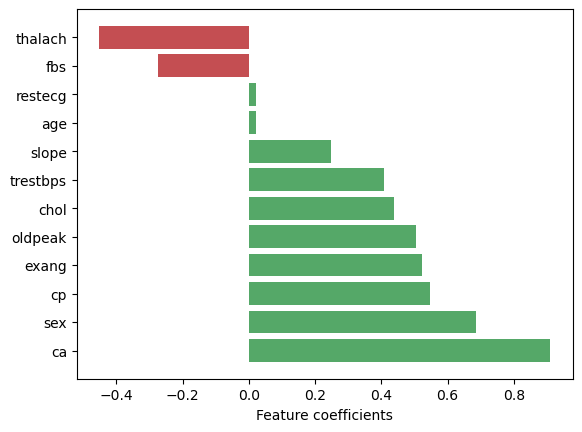

None


In [42]:
coef_dict = get_feature_coefs(lr_best)
print(visualize_coefs(coef_dict));

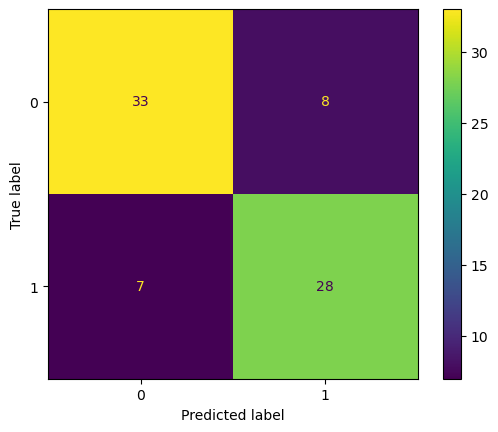

In [43]:
confusion_mat={}  # Create a dictionay to collect the confusion matrices.
cm = confusion_matrix(y_test, y_pred_lr)
confusion_mat['linear_regression'] = cm
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_best.classes_)
display.plot();

#### 2. Support vector machine model

In [44]:
param_grid = {'C': [0.1, 1, 10, 50, 100, 1000],
              'kernel': ['rbf', 'poly', 'sigmoid']
             }
svc = SVC(random_state=1)
svc_params, svc_best, y_pred_svc = grid_search(svc, param_grid, X_train, y_train, X_test, scoring='accuracy')
print('SVM, best params:')
print(svc_params)
print(svc_best)                                 
eval_mat.append(evaluate_metrics(y_test, y_pred_svc, 'SVM'))
print(pd.DataFrame(eval_mat))

SVM, best params:
{'C': 0.1, 'kernel': 'sigmoid'}
SVC(C=0.1, kernel='sigmoid', random_state=1)
                type  accuracy       auc  recall  precision    fscore
0  Linear_regression  0.802632  0.802439     0.8   0.777778  0.788732
1                SVM  0.815789  0.814634     0.8   0.800000  0.800000


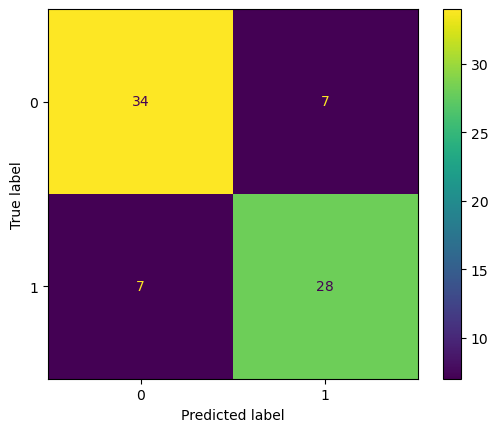

In [45]:
cm = confusion_matrix(y_test, y_pred_svc)
confusion_mat['SVM'] = cm
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_best.classes_)
display.plot();

#### 3. Random forest model

In [46]:
param_grid = {'n_estimators': [i for i in range(30, 120, 3)],
             'max_depth': [i for i in range(1, 10, 1)],
             'max_features': [0.3, 0.6],
             'max_samples': [0.5, 0.7],
             'min_samples_leaf':[1, 2],
             'min_samples_split': [2, 3],
             'n_jobs': [-1]
             }
print(param_grid)

{'n_estimators': [30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'max_features': [0.3, 0.6], 'max_samples': [0.5, 0.7], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 3], 'n_jobs': [-1]}


In [47]:
rf = RandomForestClassifier(random_state=1)
rf_params, rf_best, y_pred_rf = grid_search(rf, param_grid, X_train, y_train, X_test, scoring='accuracy')
print('Random Forest, best params:')
print(rf_params)
print(rf_best)                                 
eval_mat.append(evaluate_metrics(y_test, y_pred_rf, 'Random_forest'))
print(pd.DataFrame(eval_mat))

Random Forest, best params:
{'max_depth': 5, 'max_features': 0.3, 'max_samples': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 63, 'n_jobs': -1}
RandomForestClassifier(max_depth=5, max_features=0.3, max_samples=0.7,
                       n_estimators=63, n_jobs=-1, random_state=1)
                type  accuracy       auc    recall  precision    fscore
0  Linear_regression  0.802632  0.802439  0.800000   0.777778  0.788732
1                SVM  0.815789  0.814634  0.800000   0.800000  0.800000
2      Random_forest  0.802632  0.798258  0.742857   0.812500  0.776119


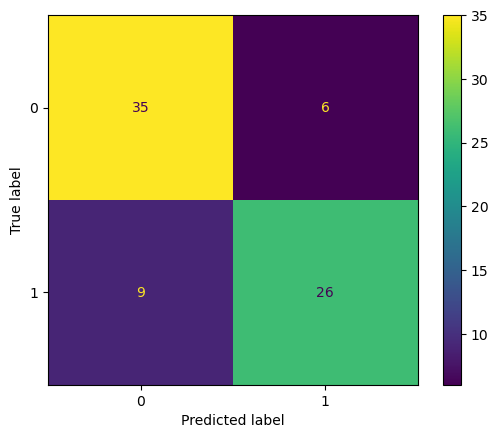

In [48]:
cm = confusion_matrix(y_test, y_pred_rf)
confusion_mat['Random_forest'] = cm
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot();

Visualize the first tree of the best model.

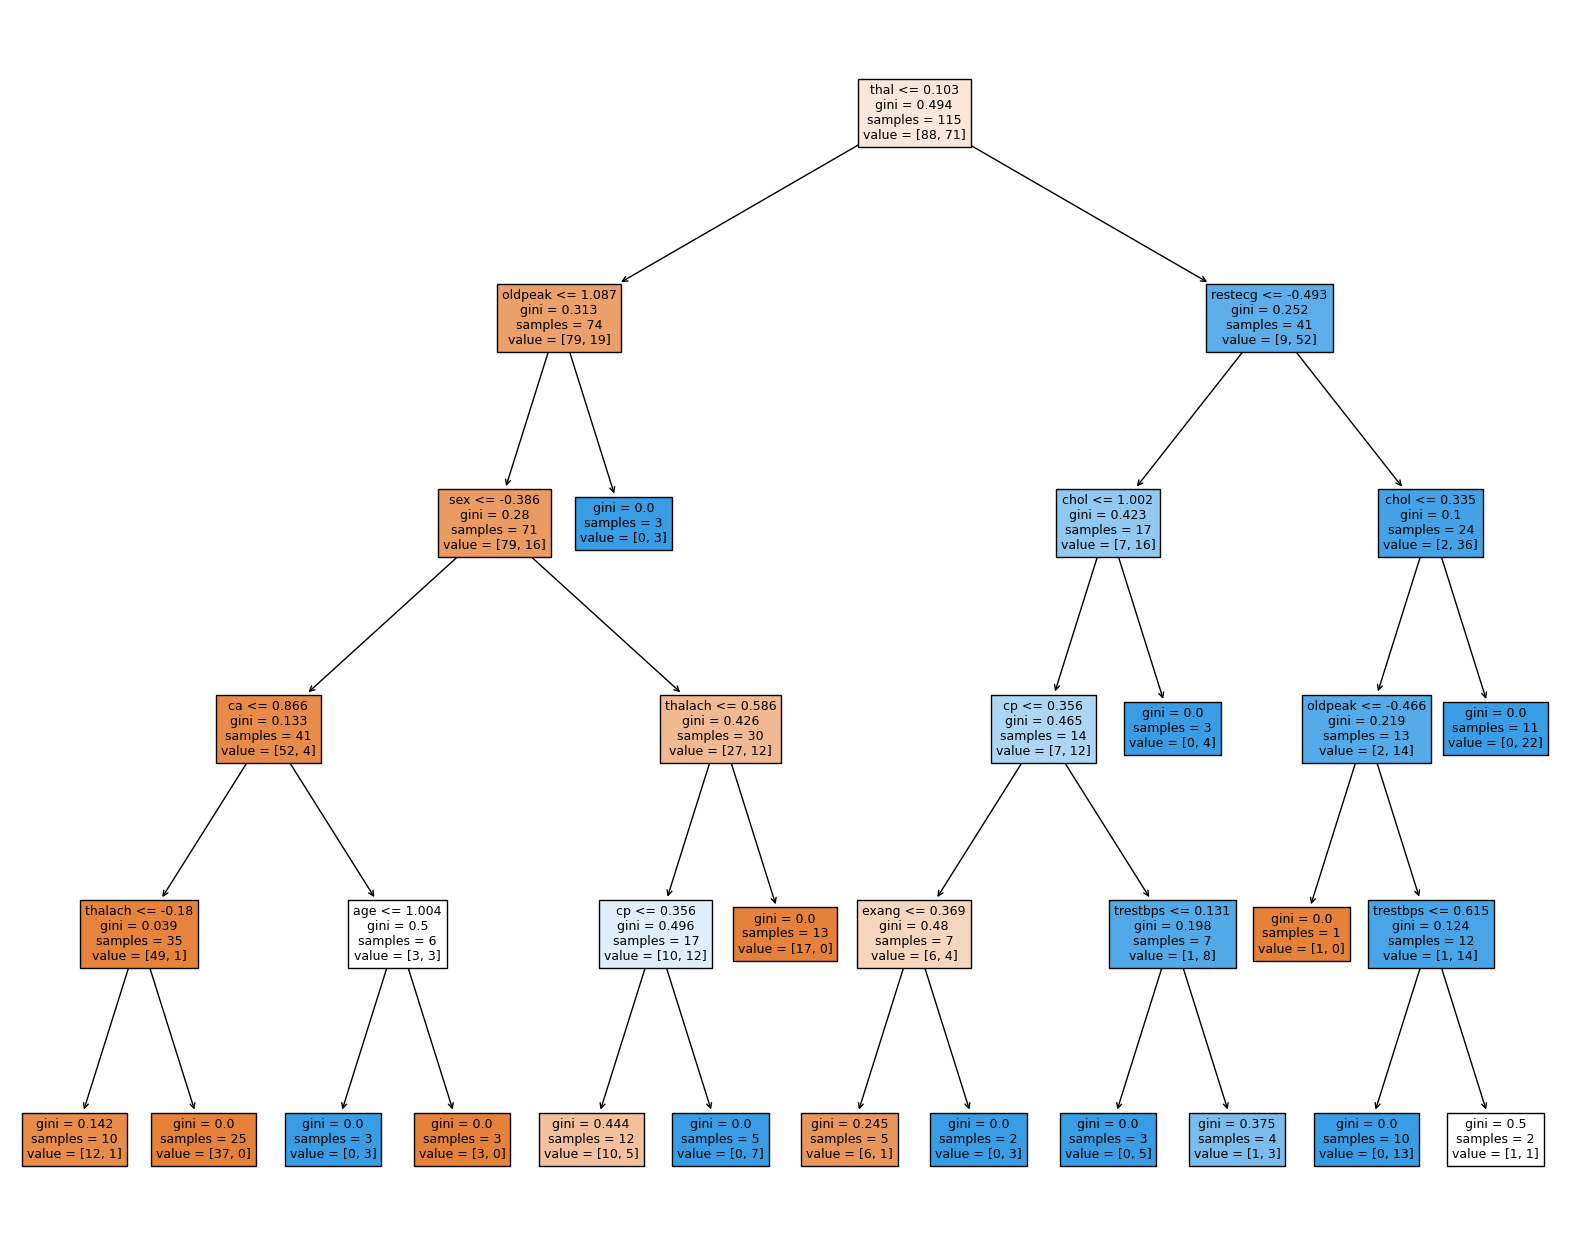

In [45]:
plot_decision_tree(rf_best[0], X.columns)

#### 4. XGBoost model

In [49]:
param_grid = {'learning_rate': [0.01, 0.02, 0.04, 0.08, 0.1, 0.12, 0.15, 0.2, 0.4, 0.6, 0.8],
             'n_estimators': [2*n+1 for n in range(21)], 
             'max_depth': list(range(1, 6))
             }
print(param_grid)

{'learning_rate': [0.01, 0.02, 0.04, 0.08, 0.1, 0.12, 0.15, 0.2, 0.4, 0.6, 0.8], 'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41], 'max_depth': [1, 2, 3, 4, 5]}


In [50]:
xgb = XGBClassifier(objective = 'binary:logistic', eval_metric='mlogloss', random_state=1)
xgb_params, xgb_best, y_pred_xgb = grid_search(xgb, param_grid, X_train, y_train, X_test, scoring='neg_log_loss')
print('XGBoost, best params:')
print(xgb_params)
print(xgb_best)                                 
eval_mat.append(evaluate_metrics(y_test, y_pred_xgb, 'XGBoost'))
print(pd.DataFrame(eval_mat))

XGBoost, best params:
{'learning_rate': 0.6, 'max_depth': 1, 'n_estimators': 27}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.6, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=1,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=27,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)
                type  accuracy       auc    recall  precision    fscore
0  Linear_regression  0.802632  0.802439  0.800000   0.777778  0.788732
1                SVM

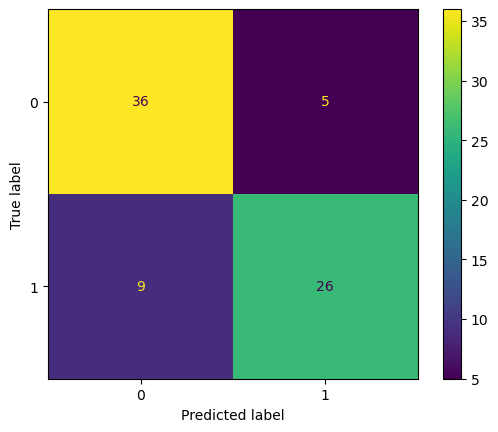

In [51]:
cm = confusion_matrix(y_test, y_pred_xgb)
confusion_mat['XGBoost'] = cm
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot();

#### 5. Summary of best hyperparameters from GridSearchCV


Logistic regression (‘penalty’: l2; ‘solver’: liblinear);  
Support vector machine ('C': 0.1, 'kernel': 'sigmoid');  
Random forest ('max_depth': 5, 'max_features': 0.3, 'max_samples': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 63);<br>
XGBoost ('learning_rate': 0.6, 'max_depth': 1, 'n_estimators': 27) ).


### Model comparison

#### 1. Metrics

In [53]:
eval_df = pd.DataFrame(eval_mat)
eval_df.columns = ['model', 'accuracy', 'recall', 'AUC', 'precision', 'f1 score']
eval_df.round(2)

,model,accuracy,recall,AUC,precision,f1 score
0,Linear_regression,0.80,0.80,0.80,0.78,0.79
1,SVM,0.82,0.81,0.80,0.80,0.80
2,Random_forest,0.80,0.80,0.74,0.81,0.78
3,XGBoost,0.82,0.81,0.74,0.84,0.79


               model  accuracy    recall       AUC  precision  f1 score
0  Linear_regression  0.802632  0.802439  0.800000   0.777778  0.788732
1                SVM  0.815789  0.814634  0.800000   0.800000  0.800000
2      Random_forest  0.802632  0.798258  0.742857   0.812500  0.776119
3            XGBoost  0.815789  0.810453  0.742857   0.838710  0.787879


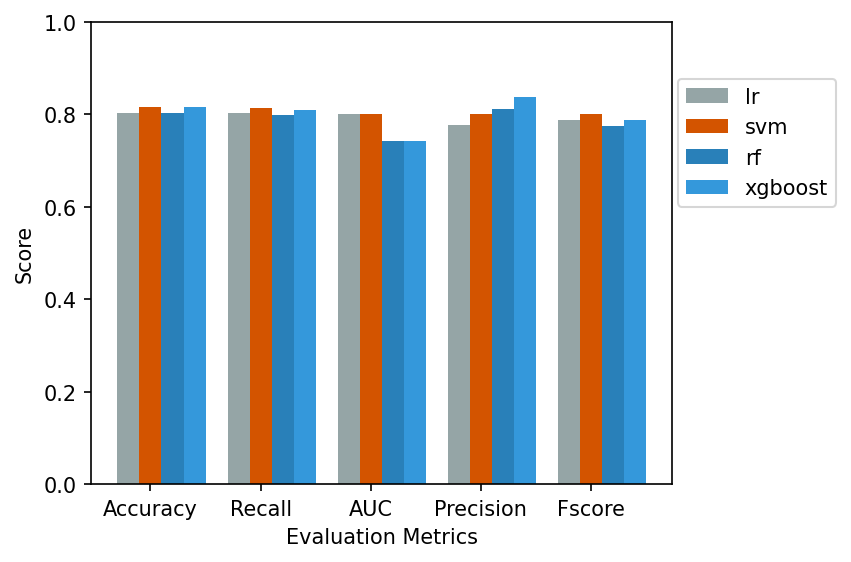

In [54]:
visualize_eval_metrics(eval_df, model_list=['lr', 'svm', 'rf', 'xgboost']);

#### 2. Confusion matrices

In [55]:
confusion_df = pd.DataFrame(index=['true negative', 'true positive'])
for key, value in confusion_mat.items():
    cd = pd.DataFrame(value, index=['true negative', 'true positive'])
    confusion_df=pd.concat([confusion_df, cd], axis=1)
model = ['linear regression', 'SVM', 'random forest', 'XGBoot']
confusion_df.columns = pd.MultiIndex.from_product([model, ['negative', 'positive']])
confusion_df

linear regression               SVM          random forest  \
                       negative positive negative positive      negative   
true negative                33        8       34        7            35   
true positive                 7       28        7       28             9   

                         XGBoot           
              positive negative positive  
true negative        6       36        5  
true positive       26        9       26

#### Metrics summary  
While overall, the performances of the four models are largely similar on this dataset. XGBoost scored the highest in precision but has lower AUC as is random forest than the other two classifiers. SVM did a slightly better than logistic regression in all scores except AUC, where they were equal.  

Consistently, the confusion matrices show that, for this dataset, logistic regression and SVM classifier produced very close results; that while random forest and XGBoost classifiers have lower false positives, they tend to have higher false negatives in comparison to logistic regression and SVM classifiers.

### 3. Feature importance

#### Logistic regression

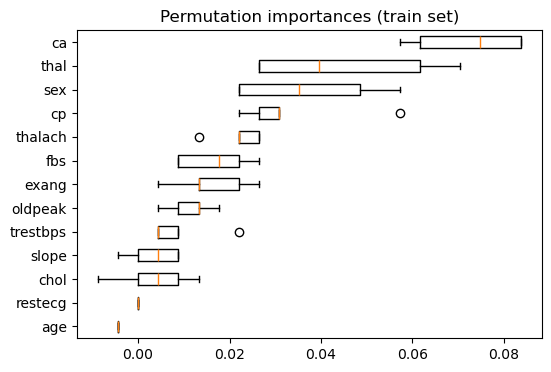

In [81]:
feature_importance = permutation_importance(estimator=lr_best,
                                            X=X_train, y=y_train, 
                                            n_repeats=5, 
                                            random_state=1)
visualize_feature_importance(feature_importance, "feature_importance_lr.png")

#### Support vector machine

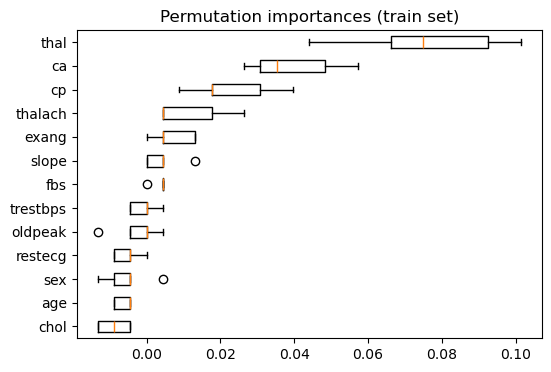

In [82]:
feature_importance = permutation_importance(estimator=svc_best,
                                            X=X_train, y=y_train, 
                                            n_repeats=5, 
                                            random_state=1)
visualize_feature_importance(feature_importance, "feature_importance_svc.png")

#### Random forest

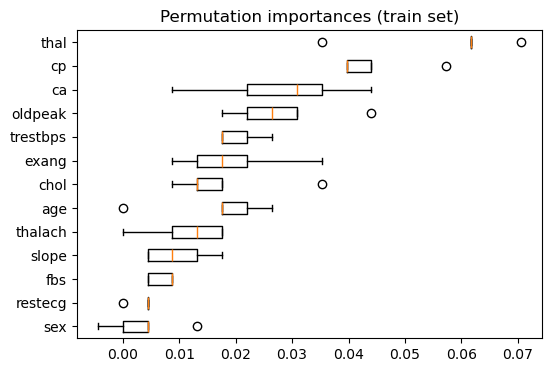

In [83]:
feature_importance = permutation_importance(estimator=rf_best,
                                            X=X_train, y=y_train, 
                                            n_repeats=5, 
                                            random_state=1)
visualize_feature_importance(feature_importance, "feature_importance_rf.png")

#### XGBoost

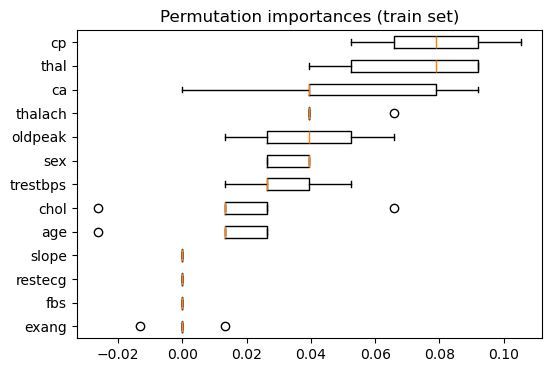

In [84]:
feature_importance = permutation_importance(estimator=xgb_best,
                                            X=X_test, y=y_test, 
                                            n_repeats=5, 
                                            random_state=1)
visualize_feature_importance(feature_importance, "feature_importance_xgboost.png")

#### Feature importance summary
As revealed by sklearn feature permutaion_importance for the training set, the first four most importance features to each classifier are: ca, thal, sex, and cp for logistic regression; thal, ca, cp, and thalach for SVM; thal, cp, ca, and oldpeak for random forest; and cp, thal, ca, and trestbps for XGBoost. Therefore, while different models look at the feature differently, they agree the importance of thal (thalassemia), ca (number of major vessels colored by flouroscopy), and cp (chest pain type) for training the models, which is clinically relevent. The three features were also important for prediction of the models as assessed with permutation_importance with the test set.

### Final model recommendation
Given the above model performance results, the SVM classifier (SVC) is recommended as the final model for its short training time and relatively good explainability. While logistic regression has better explainability than SVM, its overall performance was slightly worse than SVM. Random forest and XGBoost are not recommended because they predict more false negative; we would prefer false positive than ove false negative because heart disease can be life-threatening. We would choose potential patients for further medical evaluations rather than missing cases.

### Summary of key findings and insights
The four classifiers trained have mostly similar prediction performance with ~ 0.8 prediction accuracy; random forest and XGBoost appeared to have slightly high precision (0.81, 0.84, respectively) but lower recall than logistic regression and SVM (0.78, 0.8, respectively). Overall SVM performed slightly better than logistic regression, therefore is recommended as the final model. The two esemble models were not recommended because they tend to prodict more false negatives, which is not desirable clinically. Three features, thal (thalassemia), ca (number of major vessels colored by flouroscopy), and cp (chest pain type), were identified as the most importance feature in common for these models, which are clinically relevant.

### Further data analysis and model improvement
The models could be improved by further feature engineering (add polynomial features for logistic regression for example, which was suggested by the performance of SVM), fine tuning of the parameters, and removing those features deemed unimportant by the models. Because the original dataset has 76 attributes, it is possible to include some of them guided by clinical evidence. Further, the dataset deposit includes three sets of data beside the one used here, which are worthy of exploration. Note that this dataset was processed and is unusual in terms of class balance: real clinical data may only have a small portion of patients with heart diseases. Ultimately, as heart diseases are complex and typically multifactorial, for a model to generalize well to new datasets, a larger sample size may be needed to improve the recall and precision of the model and to finer assessment of the features.  

Thank you!